**臺灣大學 會計學研究所 李 涵 r09722057**

前處理步驟：

1. 先從原始資料中篩選上市、上櫃且非金融業的資料。
2. 將asset, income, cash三種資料合併起來變為df_final。
3. 從df_final中建構出year_data這個矩陣，用來記錄公司在哪幾年是有資料的。
4. EDA
   1. 先看每個欄位null以及值為0的比例。
      1. 依照年份去看
      2. 依照產業去看
5. 依照EDA的結果篩選x要放哪些欄位。
5. 利用for迴圈將資料整理成 ex.每間公司的三年資產負債表 + 兩年綜合損益表 + 兩年現金流量表的欄位。

# **Financial Report Analysis and Earnings Forecasting：Application of Machine Learning Models**

In [ ]:
seed_value= 0
import os
import numpy as np
import random
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(seed_value)
random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.keras.utils.set_random_seed(seed_value)
from tensorflow.keras.utils import plot_model

import pandas as pd
import pickle
import copy
import seaborn as sns 
import timeit
import scipy
import math
import keras
import gc
import warnings
warnings.filterwarnings("ignore")

from google.colab import files
from matplotlib import cm
from pandas import ExcelWriter
from functools import reduce
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.3f' % x)
np.set_printoptions(suppress=True)

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

# Create Dataset
1. collect historical financial data of companies that were listed on the Taiwan Stock Exchange(TWSE) or Taipei Exchange(TPEx) from 2012 to 2017 and are not in the financial or securities industry.

2. use past three years' accounting information to forecast next year's earnings per share (EPS) or diluted EPS, that is, there are two dependent variables aka models' learning objectives in this project, besides, accounting information means data in the balance sheet, comprehensive income statement, or cash flow statement.


In [3]:
# read files
file_path = '/content/欄位確認_final.xlsx'
asset = pd.read_excel(file_path, sheet_name='資產負債表')
income = pd.read_excel(file_path, sheet_name='損益表')
cash = pd.read_excel(file_path, sheet_name='現金流量表')
company_industry = pd.read_excel('/content/公司_產業_final.xlsx')
eps_df = pd.read_excel('/content/每股盈餘.xlsx')

In [4]:
# select companies that are TWSE-listed or TPEx-listed but not in the financial or securities industry
delete_industry = ['證券', '本國銀行', '產險業', '票券公司', '壽險業', '信託公司', '金融控股', '投信業', '證金公司', '投資業', '保險經紀', '期貨']
filter1 = (company_industry['上市別'].isin(['OTC', 'TSE']))
filter2 = (~company_industry['TEJ產業_名稱'].isin(delete_industry))
need_company = company_industry[filter1 & filter2]['公司簡稱']

In [5]:
df = [asset, income, cash]
df_final = reduce(lambda left, right: pd.merge(left, right, on=['公司', '年月'], how='left'), df)
df_final = df_final[df_final['公司'].isin(need_company)]
eps_df['市值'] = eps_df['市值(百萬元)']*1000000
eps_df['流通在外股數'] = eps_df['流通在外股數(千股)']*1000
df_final = df_final.merge(eps_df[['公司', '年月', '調整因子', '收盤價(元)', '市值', '流通在外股數']], on=['公司', '年月'], how='inner')
df_final['加權平均股數'] = df_final['加權平均股數']*1000
df_final['加權平均股數－稀釋'] = df_final['加權平均股數－稀釋']*1000
df_final['每股盈餘_調整'] = df_final['每股盈餘']*df_final['調整因子']
df_final['每股盈餘－完全稀釋_調整'] = df_final['每股盈餘－完全稀釋']*df_final['調整因子']

In [6]:
# year_data: record the years in which each company has data
all_company_list = list(df_final.公司.unique())
year = ['2012-12-28', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-30', '2017-12-29']
year_data = np.zeros(shape=(len(all_company_list), len(year)))

for j in range(len(all_company_list)):
  tmp = df_final[df_final['公司']==all_company_list[j]]
  tmp1 = tmp['年月'].values
  tmp3 = np.zeros(shape=(len(year)))
  
  for i in range(tmp.shape[0]):
    if tmp3[int(str(tmp1[i])[3])-2] == 1:
        print('年份重複:', all_company_list[j])
    tmp3[int(str(tmp1[i])[3])-2] = 1
    year_data[j, :] = tmp3

In [7]:
# analyze the EPS data to confirm whether there is any abnormality
describe = df_final.describe().T
drop_index = describe[describe['count']==0].index
describe.drop(list(drop_index), axis=0, inplace=True)
describe.T[['每股盈餘', '每股盈餘_調整', '每股盈餘－完全稀釋', '每股盈餘－完全稀釋_調整', '收盤價(元)', '調整因子', '流通在外股數']]

,每股盈餘,每股盈餘_調整,每股盈餘－完全稀釋,每股盈餘－完全稀釋_調整,收盤價(元),調整因子,流通在外股數
count,9974.000,9913.000,8416.000,8364.000,9178.000,9959.000,9178.000
mean,2.114,1.696,2.151,1.798,44.036,1.107,354481132.055
std,5.494,6.453,5.632,6.017,91.026,0.879,1239567434.039
min,-57.860,-181.454,-57.860,-92.755,1.050,0.000,5099000.000
25%,0.130,0.119,0.160,0.141,13.600,0.952,60000000.000
50%,1.290,1.224,1.310,1.250,24.500,1.000,103254500.000
75%,3.238,3.070,3.250,3.090,46.100,1.000,238619000.000
max,193.650,193.650,191.770,191.770,4020.000,37.671,25930380000.000


In [8]:
year_1 = [i[:4] for i in year]
year_2 = [year_1[i]+'變化' for i in range(1, len(year_1))]

In [9]:
# the number of company of each industry
industry_count = pd.DataFrame(company_industry[company_industry['公司簡稱'].isin(df_final['公司'])].TEJ產業_名稱.value_counts())
industry_count.columns = ['公司數量']
industry_count.head(3)

,公司數量
電子零組件,188
半導體,142
光電/ IO,130


In [10]:
# use past three years' financial data to predict next year's eps, 
# so I want to see the correlation between past three years' financial data and next year's eps 
df_pivot = df_final.pivot(index='公司', columns='年月')
result_3year = pd.DataFrame()
for i in range(3, 6):
  tmp = df_pivot.loc[:, pd.IndexSlice[:, year[i-3:i]]]
  tmp1 = df_pivot.loc[:, pd.IndexSlice[['每股盈餘'], year[i]]]
  tmp2 = pd.concat([tmp, tmp1], axis=1)
  top20_index = pd.DataFrame(tmp2.corr().loc[:,[('每股盈餘', year[i])]].sort_values(by=[('每股盈餘', year[i])], ascending=False).iloc[:41,:].index)
  if i == 3:
    result_3year = top20_index
  else:
    result_3year = pd.concat([result_3year, top20_index], axis=1)

result_3year.columns = year_1[3:]

# analysis_column: record the non-duplicate columns in result_3year
analysis_column = []
for i in result_3year.columns:
  analysis_column += list(result_3year.loc[:, i])
analysis_column = list(set(analysis_column))

In [11]:
asset_columns = ['現金及約當現金', '透過損益按公允價值衡量之金融資產－流動', '透過其他綜合損益按公允價值衡量之金融資產－流動',
       '按攤銷後成本衡量之金融資產－流動', '避險之金融資產－流動', '合約資產－流動', '應收帳款及票據', '其他應收款',
       '資金貸予他人－流動', '存貨', '待出售非流動資產', '當期所得稅資產－流動', '流動資產',
       '透過損益按公允價值衡量之金融資產－非流動', '透過其他綜合損益按公允價值衡量之金融資產－非流動', '按攤銷後成本衡量之金融資產－非流動',
       '避險之金融資產－非流動', '合約資產－非流動', '採權益法之長期股權投資', '預付投資款', '不動產廠房及設備',
       '商譽及無形資產合計', '遞延所得稅資產', '遞延資產合計', '使用權資產', '投資性不動產淨額', '其他非流動資產',
       '非流動資產', '資產總額', '短期借款', '應付商業本票∕承兌匯票', '透過損益按公允價值衡量之金融負債－流動',
       '避險之金融負債－流動', '按攤銷後成本衡量之金融負債－流動', '合約負債－流動', '應付帳款及票據', '其他應付款',
       '當期所得稅負債', '負債準備－流動', '與待出售非流動資產直接相關之負債', '租賃負債─流動', '一年內到期長期負債',
       '特別股負債－流動', '流動負債', '透過損益按公允價值衡量之金融負債－非流動', '避險之金融負債－非流動',
       '按攤銷後成本衡量之金融負債－非流動', '合約負債－非流動', '特別股負債－非流動', '應付公司債－非流動', '銀行借款－非流動',
       '其他長期借款－非流動', '租賃負債－非流動', '負債準備－非流動', '遞延貸項', '應計退休金負債', '遞延所得稅',
       '非流動負債', '負債總額', '普通股股本', '特別股股本', '預收股款', '待分配股票股利', '換股權利證書', '股本',
       '資本公積合計', '法定盈餘公積', '特別盈餘公積', '未分配盈餘', '保留盈餘', '其他權益', '庫藏股票帳面值',
       '母公司股東權益合計', '共同控制下前手權益', '合併前非屬共同控制股權', '非控制權益', '股東權益總額',
       '負債及股東權益總額']

income_columns = ['營業收入淨額', '營業成本', '營業毛利', '聯屬公司已（未）實現銷貨利益', '已實現銷貨毛利',
       '營業費用', '研究發展費', '預期信用減損（損失）利益－營業費用', '其他收益及費損淨額', '營業利益', '利息收入',
       '其他收入', '其他利益及損失', '財務成本', '採權益法之關聯企業及合資損益之份額', '預期信用減損（損失）利益',
       '除列按攤銷後成本衡量金融資產淨損益', '金融資產重分類淨損益', '營業外收入及支出－其他', '營業外收入及支出', '稅前淨利',
       '所得稅費用', '繼續營業單位損益', '停業單位損益', '合併前非屬共同控制股權損益', '其他損益調整項－非常項目及累計影響數',
       '合併總損益', '不重分類至損益之項目－OCI', '後續可能重分類至損益之項目－OCI', '合併前非屬共同控制股權綜合損益淨額－OCI',
       '其他綜合損益－OCI', '本期綜合損益總額', '歸屬母公司淨利（損）', '歸屬非控制權益淨利（損）', '歸屬共同控制下前手權益淨利（損）',
       '綜合損益歸屬母公司', '綜合損益歸屬非控制權益', '綜合損益歸屬共同控制下前手權益', '加權平均股數', '發放特別股股息', '稀釋稅後淨利',
       '加權平均股數－稀釋', '稅前息前淨利', '稅前息前折舊前淨利', '常續性稅後淨利']

cash_columns = ['稅前淨利－CFO', '折舊－CFO', '攤提－CFO', '來自營運之現金流量', '新增投資－CFI',
       '出售投資－CFI', '購置不動產廠房設備（含預付）－CFI', '處分不動產廠房設備（含預付）－CFI', '投資活動之現金流量',
       '現金增（減）資－CFF', '支付現金股利－CFF', '籌資活動之現金流量', '匯率影響數', '本期產生現金流量',
       '期初現金及約當現金', '期末現金及約當現金', '收盤價(元)', '市值', '流通在外股數']

y_columns = ['每股盈餘_調整', '每股盈餘－完全稀釋_調整']

# colums that are more correlated with eps
corr_column = ['不動產廠房及設備', '當期所得稅負債', '未分配盈餘', '保留盈餘', '營業毛利', '已實現銷貨毛利', '營業費用',
               '營業利益', '稅前淨利', '所得稅費用', '繼續營業單位損益', '合併總損益', '本期綜合損益總額', '歸屬母公司淨利（損）',
               '綜合損益歸屬母公司', '稀釋稅後淨利', '稅前息前淨利', '稅前息前折舊前淨利', '常續性稅後淨利', '每股盈餘_調整',
               '每股盈餘－完全稀釋_調整', '稅前淨利－CFO', '本期產生現金流量']

# need to remove columns in delete_list from dataset, because these columns are composed of a lot of null
delete_list = ['合約負債－非流動', '待分配股票股利', '預期信用減損（損失）利益－營業費用', '預期信用減損（損失）利益', '合併前非屬共同控制股權損益', '特別股負債－流動',
'營業外收入及支出－其他', '其他損益調整項－非常項目及累計影響數', '合併前非屬共同控制股權綜合損益淨額－OCI', '合併前非屬共同控制股權', '合約資產－非流動', '使用權資產',
'按攤銷後成本衡量之金融負債－流動', '租賃負債─流動', '按攤銷後成本衡量之金融負債－非流動', '租賃負債－非流動', '除列按攤銷後成本衡量金融資產淨損益', '金融資產重分類淨損益', '發放特別股股息']

In [12]:
def delete_columns(columns, delete_list):
  tmp = []
  for i in columns:
    if i not in delete_list:
      tmp.append(i)
  return tmp 

asset_col = delete_columns(asset_columns, delete_list)
income_col = delete_columns(income_columns, delete_list)
cash_col = delete_columns(cash_columns, delete_list)

In [13]:
# convert dataset into the form that models need
def create_data(asset_col, income_col, cash_col, eps_col, y, df_final, asset_start, asset_end, income_start, income_end):
  tmp_df = df_final.pivot(index='公司', columns='年月')
  year_index = asset_end + 1
  asset_start = asset_start - 2012
  asset_end = asset_end - 2012 + 1
  income_start = income_start - 2012
  income_end = income_end - 2012 + 1

  company_name = np.array(all_company_list)[np.where(np.sum(year_data[:, asset_start:asset_end], axis=1) == 3)[0]]
  
  asset_part = tmp_df.loc[company_name, pd.IndexSlice[asset_col, year[asset_start:asset_end]]]  
  income_part = tmp_df.loc[company_name, pd.IndexSlice[income_col+eps_col, year[income_start:income_end]]] 
  cash_part = tmp_df.loc[company_name, pd.IndexSlice[cash_col, year[income_start:income_end]]] 
  y_part = tmp_df.loc[company_name, pd.IndexSlice[y, year[asset_end]]] 
  all_x = asset_part.join(income_part).join(cash_part).join(y_part)
  all_x.index = np.core.defchararray.add(company_name, np.array(['_'+str(year_index)]))

  return all_x[~all_x[(y, year[asset_end])].isnull()]

need_data = []
for i in y_columns:
  data_2015 = create_data(asset_col, income_col, cash_col, y_columns, i, df_final, 2012, 2014, 2013, 2014)
  data_2016 = create_data(asset_col, income_col, cash_col, y_columns, i, df_final, 2013, 2015, 2014, 2015)
  data_2017 = create_data(asset_col, income_col, cash_col, y_columns, i, df_final, 2014, 2016, 2015, 2016)
  need_data.append([data_2015, data_2016, data_2017])

In [14]:
# some rows of dataset need to be removed because data feature preprocessing method proposed below can't tolerate existance of 0 or null
def remove_row(data, year_list):
  null_list = ['營業收入淨額', '資產總額', '收盤價(元)', '市值', '流通在外股數', '加權平均股數', '加權平均股數－稀釋', '每股盈餘_調整', '每股盈餘－完全稀釋_調整']
  for i in null_list:
    if i in ['營業收入淨額']:
      data = data[(~data[i, year_list[1]].isin([np.nan, 0])) & (~data[i, year_list[2]].isin([np.nan, 0]))]
    elif i in ['每股盈餘_調整', '每股盈餘－完全稀釋_調整']: 
      data = data[(~data[i, year_list[1]].isin([np.nan])) & (~data[i, year_list[2]].isin([np.nan]))]
    elif i in ['資產總額']:
      data = data[(~data[i, year_list[0]].isin([np.nan, 0])) & (~data[i, year_list[1]].isin([np.nan, 0])) & (~data[i, year_list[2]].isin([np.nan, 0]))]
    elif i in ['收盤價(元)', '流通在外股數', '市值', '加權平均股數', '加權平均股數－稀釋']:
      data = data[(~data[i, year_list[2]].isin([np.nan, 0]))]
  return data

for i in range(len(need_data)):
  need_data[i][0] = remove_row(need_data[i][0], year[0:3])
  need_data[i][1] = remove_row(need_data[i][1], year[1:4])
  need_data[i][2] = remove_row(need_data[i][2], year[2:5])

In [15]:
need_data[0][0].head(3)

現金及約當現金                                  \
年月                2012-12-28      2013-12-31      2014-12-31   
1101 台泥_2015 25611406000.000 25711065000.000 30514042000.000   
1102 亞泥_2015  8309069000.000 19184742000.000 12739834000.000   
1103 嘉泥_2015  4284000000.000  3294619000.000  3163688000.000   

             透過損益按公允價值衡量之金融資產－流動                                \
年月                    2012-12-28     2013-12-31     2014-12-31   
1101 台泥_2015       148527000.000  215182000.000  176865000.000   
1102 亞泥_2015       718691000.000  760570000.000  743682000.000   
1103 嘉泥_2015      1836781000.000 2313953000.000 1671024000.000   

             透過其他綜合損益按公允價值衡量之金融資產－流動                                  \
年月                        2012-12-28      2013-12-31      2014-12-31   
1101 台泥_2015         15751741000.000 19165866000.000 19615395000.000   
1102 亞泥_2015          6608175000.000  9074555000.000 16949278000.000   
1103 嘉泥_2015          3425708000.000  4031734000.000  3708575000.000   

             按攤銷後成本衡量之金融資產－流動                               避險之金融資產－流動  \
年月                 2012-12-28     2013-12-31     2014-12-31 2012-12-28   
1101 台泥_2015            0.000          0.000          0.000 206000.000   
1102 亞泥_2015   8385707000.000 6731406000.000 5834881000.000      0.000   
1103 嘉泥_2015            0.000          0.000          0.000      0.000   

                                        合約資產－流動                        \
年月             2013-12-31 2014-12-31 2012-12-28 2013-12-31 2014-12-31   
1101 台泥_2015 11810000.000      0.000      0.000      0.000      0.000   
1102 亞泥_2015        0.000      0.000      0.000      0.000      0.000   
1103 嘉泥_2015        0.000      0.000      0.000      0.000      0.000   

                     應收帳款及票據                                          其他應收款  \
年月                2012-12-28      2013-12-31      2014-12-31     2012-12-28   
1101 台泥_2015 19498993000.000 25597371000.000 26543620000.000 2143543000.000   
1102 亞泥_2015 16368890000.000 17467028000.000 20154888000.000  454500000.000   
1103 嘉泥_2015   610243000.000   745685000.000   578836000.000   83700000.000   

                                                資金貸予他人－流動                \
年月               2013-12-31     2014-12-31     2012-12-28    2013-12-31   
1101 台泥_2015 1539157000.000 2150436000.000 1220456000.000 244277000.000   
1102 亞泥_2015 2470991000.000 2633755000.000          0.000         0.000   
1103 嘉泥_2015  105937000.000  103463000.000   34700000.000  34217000.000   

                                        存貨                                 \
年月               2014-12-31     2012-12-28     2013-12-31      2014-12-31   
1101 台泥_2015 1962202000.000 9645715000.000 9286227000.000 10470879000.000   
1102 亞泥_2015          0.000 7515813000.000 7863420000.000  9416977000.000   
1103 嘉泥_2015  210017000.000  958623000.000 1312784000.000  1148184000.000   

               待出售非流動資產                          當期所得稅資產－流動               \
年月           2012-12-28 2013-12-31    2014-12-31 2012-12-28   2013-12-31   
1101 台泥_2015      0.000      0.000         0.000      0.000        0.000   
1102 亞泥_2015      0.000      0.000         0.000      0.000 11774000.000   
1103 嘉泥_2015      0.000      0.000 147940000.000 700000.000  6054000.000   

                                     流動資產                                  \
年月             2014-12-31      2012-12-28      2013-12-31      2014-12-31   
1101 台泥_2015        0.000 80534379000.000 87788055000.000 96605816000.000   
1102 亞泥_2015  1251000.000 49663040000.000 65337233000.000 70558875000.000   
1103 嘉泥_2015 14173000.000 12515670000.000 13570784000.000 12878015000.000   

             透過損益按公允價值衡量之金融資產－非流動                                \
年月                     2012-12-28     2013-12-31     2014-12-31   
1101 台泥_2015        616193000.000  579192000.000  546028000.000   
1102 亞泥_2015       1222800000.000 1485416000.000 1432927000.000   
1103 嘉泥_2015        529420000.000  513258000.000  489780000.000   

          

# Data Preprocessing
1. propose five data feature preprocessing methods to preprocess the dataset and eliminate the size gap between different companies.

2. method 1: columns from annual balance sheet are divided by the total assets of the year, columns from the annual comprehensive income statement and cash flow statement are divided by the net operating income of the year, and eps-related columns are divided by closing price on the last trading day of the third year.

3. method 2: divide the eps-related columns by the closing price on the last trading day of the third year, and divide all other columns of dataset by the market value at the end of the third year.

4. method 3: standardization.

5. method 4: except for the eps-related columns, other columns of dataset are divided by the number of outstanding shares at the end of the third year first, and then are standardized.

6. method 5: except for the eps-related columns, other columns of dataset are divided by weighted average number of shares at the end of the third year, and then are standardized.

In [97]:
# method 1
def divide_total_asset(x, asset_col, income_col, cash_col, eps_col, y, year_list):
  drop_list = ['資產總額', '營業收入淨額', '負債及股東權益總額', '收盤價(元)', '流通在外股數', '市值']
  x1 = copy.deepcopy(x)
  
  for i in year_list[0:3]: 
    for column in asset_col:
      if column == '資產總額':
        continue
      x1[column, i] = x1[column, i]/x1['資產總額', i] 

  for j in year_list[1:3]: 
    for column in income_col+cash_col:
      if column in (['營業收入淨額', '收盤價(元)', '市值', '流通在外股數']): 
        continue
      x1[column, j] = x1[column, j]/x1['營業收入淨額', j] 

    for eps_column in eps_col:
      x1[eps_column, j] = x1[eps_column, j]/x1['收盤價(元)', year_list[-2]] 

  x1[y, year_list[-1]] = x1[y, year_list[-1]]/x1['收盤價(元)', year_list[-2]]

  for t in drop_list:
    x1.drop(t, axis=1, level=0, inplace=True)

  return x1


# method 2
def divide_market_value(x, eps_col, year_list):
  drop_list = ['市值', '收盤價(元)', '流通在外股數']
  x1 = copy.deepcopy(x)
  
  for i in x1.columns:
    if i[0] in eps_col:
      x1[i] = x1[i]/x1['收盤價(元)', year_list[-2]]
    elif i[0] in drop_list:
      continue
    else:
      x1[i] = x1[i]/x1['市值', year_list[-2]]
  
  for t in drop_list:
    x1.drop(t, axis=1, level=0, inplace=True)

  return x1


# method 4 & 5
def divide_stock_number(x, eps_col, year_list, mode='流通在外股數'):
  drop_list = ['市值', '收盤價(元)', '流通在外股數']
  x1 = copy.deepcopy(x)

  if mode != '流通在外股數':
    drop_list += [mode]

  for i in x1.columns:
    if i[0] in eps_col+drop_list:
      continue
    else:
      x1[i] = x1[i]/x1[mode, year_list[-2]]
  
  for t in drop_list:
    x1.drop(t, axis=1, level=0, inplace=True)

  return x1

# Hyperparameter Tuning & Build Models & Forecast EPS
1. use cross validation method and grid search skill to tune hyperparameters.

2. build 156 models including 72 random forest regressors, 72 xgboost regressors, 6 dnn models and 6 lstm models.

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Activation, LeakyReLU, Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.utils import shuffle

In [18]:
# save and reload dictionary
def save_dict(file, file_name):
  with open(file_name, 'wb') as f:
    pickle.dump(file, f)
  files.download(file_name)

def reload_dictionary(file_path):
  with open(file_path, 'rb') as f:
     return pickle.load(f)

## Hyperparameter Tuning & Train Models & Predict
### - random forest regressor, xgboost regressor - 

In [19]:
# MAE function & scorer function: self-defined scoring function for Pipeline
def MAE(y_true, y_pred):

    global count, train_valid_num, train_price, cv_list
    train_price_cv = train_price[cv_list[count][0]]
    valid_price_cv = train_price[cv_list[count][1]]

    if y_pred.shape[0] == train_price_cv.shape[0]:
      y_pred = y_pred*train_price_cv.values
      y_true = y_true*train_price_cv
    else:
      y_pred = y_pred*valid_price_cv.values
      y_true = y_true*valid_price_cv

    mae = mean_absolute_error(y_true, y_pred)

    train_valid_num += 1
    if train_valid_num == 2:
      count += 1
      train_valid_num = 0

    if count == 5:
      count = 0

    return mae


def scorer():
    return make_scorer(MAE, greater_is_better=False)


# because EPS is divided by the closing price at the data preprocessing step, 
# the value predicted by the model and the actual y value in the test dataset must be multiplied by the closing price first before calculating the mean absolute error
def y_divide_price(y_pred_test, y_test, y_pred_train, y_train, test_price, train_price):
    y_pred_test = y_pred_test * test_price.values.reshape(-1) 
    y_test = y_test * test_price
    y_pred_train = y_pred_train * train_price.values.reshape(-1)
    y_train = y_train * train_price
    return y_pred_test, y_test, y_pred_train, y_train


def y_standardization(y_pred_test, y_test, y_pred_train, y_train, y_train_mean, y_train_std):
    y_pred_test = y_pred_test * y_train_std + y_train_mean 
    y_pred_train = y_pred_train * y_train_std + y_train_mean 
    y_train = y_train * y_train_std + y_train_mean 
    y_test = y_test * y_train_std + y_train_mean 
    return y_pred_test, y_test, y_pred_train, y_train


# record the ouput of models
def record_result(tmp_dict, y_test, y_pred_test, y_train, y_pred_train, last_eps_test, last_eps_train, columns=None, feature_importance=None, best_param=None, cv_result=None):
  tmp_dict['rmse'] = [round(mean_squared_error(y_train, y_pred_train, squared=False), 4), round(mean_squared_error(y_test, y_pred_test, squared=False), 4)]
  tmp_dict['mae'] = [round(mean_absolute_error(y_train, y_pred_train), 4), round(mean_absolute_error(y_test, y_pred_test), 4)]
  tmp_dict['y_pred'] = y_pred_test
  tmp_dict['y_true'] = y_test 
  tmp_dict['feat_importance'] = feature_importance 
  tmp_dict['columns'] = columns 
  tmp_dict['best_param'] = best_param
  tmp_dict['cv_result'] = cv_result


def rf_xgb(train, test, param, result, standardization_key, y, column_key, last_eps_train, last_eps_test, mode, cv_list, train_price=None, test_price=None):
  x_train = train.iloc[:, :-1] 
  y_train = train.iloc[:, -1]
  x_test = test.iloc[:, :-1] 
  y_test = test.iloc[:, -1] 

  if mode == 'random_forest':
    model = RandomForestRegressor()
  elif mode == 'xgboost':
    model = XGBRegressor() 
    x_test.columns = x_train.columns 
  
  if standardization_key in ['standardization', 'stock_num', 'weighted_stock_num']:
    scaler = StandardScaler()
    pipe = Pipeline(steps=[('scaler', scaler), ("model", TransformedTargetRegressor(model, transformer=StandardScaler()))])
    search = GridSearchCV(pipe, param, scoring='neg_mean_absolute_error', cv=cv_list, refit=True, return_train_score=True) 
  else: 
    search = GridSearchCV(model, param, scoring=scorer(), cv=cv_list, refit=True, return_train_score=True)

  tmp_result = search.fit(x_train, y_train)  
  best_model = tmp_result.best_estimator_
  best_param = tmp_result.best_params_
  cv_result = tmp_result.cv_results_
  y_pred_test = best_model.predict(x_test) 
  y_pred_train = best_model.predict(x_train)

  if standardization_key in ['standardization', 'stock_num', 'weighted_stock_num']:
    feature_importance = best_model.get_params()["model"].regressor_.feature_importances_ 
  else: 
    feature_importance = best_model.feature_importances_
    y_pred_test, y_test, y_pred_train, y_train = y_divide_price(y_pred_test, y_test, y_pred_train, y_train, test_price, train_price)    

  tmp_dict = result[mode][standardization_key][y][column_key]
  record_result(tmp_dict, y_test, y_pred_test, y_train, y_pred_train, last_eps_test, last_eps_train, x_train.columns, feature_importance, best_param, cv_result)



def rf_xgb_without_gridsearch(train, test, param, result, standardization_key, y, column_key, last_eps_train, last_eps_test, mode, train_price=None, test_price=None):
  
  test.columns = train.columns
  if standardization_key in ['standardization', 'stock_num', 'weighted_stock_num']:
    train_mean = train.mean()
    train_std = train.std()
    train = (train - train_mean)/train_std
    test = (test - train_mean)/train_std
    y_train_mean = train_mean[-1]
    y_train_std = train_std[-1]

  x_train = train.iloc[:, :-1] 
  y_train = train.iloc[:, -1]
  x_test = test.iloc[:, :-1] 
  y_test = test.iloc[:, -1] 

  if mode == 'random_forest':
    model = RandomForestRegressor(**param)
  elif mode == 'xgboost':
    model = XGBRegressor(**param)  

  model.fit(x_train, y_train)  
  y_pred_test = model.predict(x_test) 
  y_pred_train = model.predict(x_train)
  feature_importance = model.feature_importances_

  if standardization_key in ['standardization', 'stock_num', 'weighted_stock_num']:
    y_pred_test, y_test, y_pred_train, y_train = y_standardization(y_pred_test, y_test, y_pred_train, y_train, y_train_mean, y_train_std)
  else: 
    y_pred_test, y_test, y_pred_train, y_train = y_divide_price(y_pred_test, y_test, y_pred_train, y_train, test_price, train_price)    

  tmp_dict = result[mode][standardization_key][y][column_key]
  record_result(tmp_dict, y_test, y_pred_test, y_train, y_pred_train, last_eps_test, last_eps_train, x_train.columns, feature_importance, param)



def training_process(data_train, data_test, rf_param, xgb_param, result_dict, standardization_key, y,\
                     last_eps_train, last_eps_test, cv_list=None, train_price=None, test_price=None, gridsearch=True):
    
  for col in column_key:
    if col == 'all':
      train_final = data_train
      test_final = data_test
    elif col == 'corr':
      train_final = pd.concat([data_train.iloc[:, :-1].loc[:, pd.IndexSlice[corr_column, :]], data_train.iloc[:, -1]], axis=1)
      test_final = pd.concat([data_test.iloc[:, :-1].loc[:, pd.IndexSlice[corr_column, :]], data_test.iloc[:, -1]], axis=1)
    elif col == 'eps':
      train_final = pd.concat([data_train.iloc[:, :-1].loc[:, pd.IndexSlice[y_columns, :]], data_train.iloc[:, -1]], axis=1)
      test_final = pd.concat([data_test.iloc[:, :-1].loc[:, pd.IndexSlice[y_columns, :]], data_test.iloc[:, -1]], axis=1)
    
    if gridsearch == True:
      rf_xgb(train_final.replace(np.nan, 0), test_final.replace(np.nan, 0), rf_param, result_dict, standardization_key, y, col, last_eps_train, last_eps_test, 'random_forest', cv_list, train_price, test_price)
      rf_xgb(train_final, test_final, xgb_param, result_dict, standardization_key, y, col, last_eps_train, last_eps_test, 'xgboost', cv_list, train_price, test_price)       
    else:
      rf_xgb_without_gridsearch(train_final.replace(np.nan, 0), test_final.replace(np.nan, 0), rf_param, result_dict, standardization_key, y, col, last_eps_train, last_eps_test, 'random_forest', train_price, test_price)
      rf_xgb_without_gridsearch(train_final, test_final, xgb_param, result_dict, standardization_key, y, col, last_eps_train, last_eps_test, 'xgboost', train_price, test_price)       



In [20]:
all_data = []
for i in range(len(y_columns)):
  for j in range(3):
    if j == 2:
      tmp = copy.deepcopy(need_data[i][0])
      tmp1 = copy.deepcopy(need_data[i][1])
      tmp.columns = tmp1.columns
      train = pd.concat([tmp, tmp1], axis=0)
      test = copy.deepcopy(need_data[i][2])
      train_year = year[1:5]
      test_year = year[2:6]
    else:
      train = copy.deepcopy(need_data[i][j])
      test = copy.deepcopy(need_data[i][j+1])
      train_year = year[0+j:4+j]
      test_year = year[0+j+1:4+j+1]

    train_price = train['收盤價(元)', train_year[-2]]
    test_price = test['收盤價(元)', test_year[-2]]
    last_eps_train = train[train.columns[-1][0], train_year[-2]]
    last_eps_test = test[test.columns[-1][0], test_year[-2]]
    cv_list = list(KFold(n_splits=5, shuffle=True, random_state=0).split(train))
    all_data.append([train, test, train_price, test_price, last_eps_train, last_eps_test, train_year, test_year, cv_list])
# all_data = [0: train, 1: test, 2: train_price, 3: test_price, 4: last_eps_train, 5: last_eps_test, 6: train_year, 7: test_year, 8: cv_list]

In [ ]:
result_2016 = {'random_forest':{}, 'xgboost':{}, 'dnn':{}, 'lstm':{}}
standardization_list = ['total_asset', 'market_value', 'standardization', 'stock_num', 'weighted_stock_num']
column_key = ['all', 'corr', 'eps']

for model in result_2016.keys():
  for j in standardization_list:
    result_2016[model][j] = {i:{j:{} for j in column_key} for i in y_columns}
    
result_2016['random_walk'] = {i:{} for i in y_columns}

result_2017 = copy.deepcopy(result_2016)
result_2017_2y = copy.deepcopy(result_2016)
result = [result_2016, result_2017, result_2017_2y]

In [ ]:
# tuning hyperparameter for random forest regressor using cross validation
# all_data = [0: train, 1: test, 2: train_price, 3: test_price, 4: last_eps_train, 5: last_eps_test, 6: train_year, 7: test_year, 8: cv_list]
result_2016_rf_tuning = copy.deepcopy(result_2016)
key_list_rf = ['random_forest', 'total_asset', '每股盈餘－完全稀釋_調整', 'eps']
count = 0
train_valid_num = 0

if key_list_rf[2] == y_columns[0]:
  tmp = all_data[0]
elif key_list_rf[2] == y_columns[1]:
  tmp = all_data[3]
y = tmp[0].columns[-1][0]
train_price = tmp[2]
cv_list = tmp[8]

data_train = divide_total_asset(tmp[0], asset_col, income_col, cash_col, y_columns, y, tmp[6])
data_test = divide_total_asset(tmp[1], asset_col, income_col, cash_col, y_columns, y, tmp[7])

train_final = pd.concat([data_train.iloc[:, :-1].loc[:, pd.IndexSlice[y_columns, :]], data_train.iloc[:, -1]], axis=1)
test_final = pd.concat([data_test.iloc[:, :-1].loc[:, pd.IndexSlice[y_columns, :]], data_test.iloc[:, -1]], axis=1)

rf_param_cv = {"n_estimators":[50, 80, 100], "max_depth":[3, 4, 5, 6], "max_features":["auto", "log2"], "min_samples_split":[2, 3, 4],\
               "min_samples_leaf":[1, 2, 3], "max_samples":[0.4, 0.45, 0.5, 0.55, 1.0], "oob_score":[True], "random_state":[1115], "n_jobs":[-1], "verbose":[0], "criterion":['absolute_error']}

rf_xgb(train_final.replace(np.nan, 0), test_final.replace(np.nan, 0), rf_param_cv, result_2016_rf_tuning, key_list_rf[1], y, key_list_rf[3], tmp[4], tmp[5], key_list_rf[0], cv_list, tmp[2], tmp[3])

In [ ]:
# tuning hyperparameters for xgboost regressor using cross validation
# all_data = [0: train, 1: test, 2: train_price, 3: test_price, 4: last_eps_train, 5: last_eps_test, 6: train_year, 7: test_year, 8: cv_list]
result_2016_xgb_tuning = copy.deepcopy(result_2016)
key_list_xgb = ['xgboost', 'total_asset', '每股盈餘－完全稀釋_調整', 'eps']
count = 0
train_valid_num = 0

if key_list_xgb[2] == y_columns[0]:
  tmp = all_data[0]
elif key_list_xgb[2] == y_columns[1]:
  tmp = all_data[3]
y = tmp[0].columns[-1][0]
train_price = tmp[2]
cv_list = tmp[8]

data_train = divide_total_asset(tmp[0], asset_col, income_col, cash_col, y_columns, y, tmp[6])
data_test = divide_total_asset(tmp[1], asset_col, income_col, cash_col, y_columns, y, tmp[7])

train_final = pd.concat([data_train.iloc[:, :-1].loc[:, pd.IndexSlice[y_columns, :]], data_train.iloc[:, -1]], axis=1)
test_final = pd.concat([data_test.iloc[:, :-1].loc[:, pd.IndexSlice[y_columns, :]], data_test.iloc[:, -1]], axis=1)

xgb_param_cv = {"n_estimators":[40, 45], "max_depth":[4, 5], "learning_rate":[0.1, 0.105, 0.11], "objective":['reg:squarederror'],\
                "random_state":[1115], "verbosity":[0], "booster":['gbtree'], "n_jobs":[-1], "subsample":[0.9, 0.95, 1.0], "colsample_bytree":[0.8, 0.9, 1.0],\
                "gamma":[0.075, 0.1, 0.125, 0.15], "reg_alpha":[0.05, 0.1, 0.2], "reg_lambda":[0.9, 1.0, 1.1], "tree_method":["exact"]}

rf_xgb(train_final, test_final, xgb_param_cv, result_2016_xgb_tuning, key_list_xgb[1], y, key_list_xgb[3], tmp[4], tmp[5], key_list_xgb[0], cv_list, tmp[2], tmp[3])

In [ ]:
# record best parameter from the above validation process
rf_param = result_2016_rf_tuning[key_list_rf[0]][key_list_rf[1]][key_list_rf[2]][key_list_rf[3]]['best_param']
xgb_param = result_2016_xgb_tuning[key_list_xgb[0]][key_list_xgb[1]][key_list_xgb[2]][key_list_xgb[3]]['best_param']

In [ ]:
# train models
for std in standardization_list:
  for i in range(len(all_data)): 
    y = all_data[i][0].columns[-1][0]
    tmp = all_data[i]

    if std == 'total_asset':
      data_train = divide_total_asset(tmp[0], asset_col, income_col, cash_col, y_columns, y, tmp[6])
      data_test = divide_total_asset(tmp[1], asset_col, income_col, cash_col, y_columns, y, tmp[7])
    elif std == 'market_value':
      data_train = divide_market_value(tmp[0], y_columns, tmp[6])
      data_test = divide_market_value(tmp[1], y_columns, tmp[7])
    elif std == 'standardization':
      data_train = copy.deepcopy(tmp[0])
      data_train.drop(['收盤價(元)', '流通在外股數', '市值'], axis=1, level=0, inplace=True)
      data_test = copy.deepcopy(tmp[1])
      data_test.drop(['收盤價(元)', '流通在外股數', '市值'], axis=1, level=0, inplace=True)
    elif std == 'stock_num':
      data_train = divide_stock_number(tmp[0], y_columns, tmp[6], mode='流通在外股數')
      data_test = divide_stock_number(tmp[1], y_columns, tmp[7], mode='流通在外股數')
    elif std == 'weighted_stock_num':
      if i <= 2:
        stock_type = '加權平均股數'
      else:
        stock_type = '加權平均股數－稀釋'
      data_train = divide_stock_number(tmp[0], y_columns, tmp[6], mode=stock_type)
      data_test = divide_stock_number(tmp[1], y_columns, tmp[7], mode=stock_type)

    if i % 3 == 0:
      result_dict = result_2016
    elif i % 3 == 1:
      result_dict = result_2017
    elif i % 3 == 2:
      result_dict = result_2017_2y

    training_process(data_train, data_test, rf_param, xgb_param, result_dict, std, y, tmp[4], tmp[5], tmp[8], tmp[2], tmp[3], False)

In [ ]:
# random_walk: last year's EPS is directly used as the forecast value for the next year
for i in range(len(all_data)):
  train = all_data[i][0]
  test = all_data[i][1]
  last_eps_train = all_data[i][4] 
  last_eps_test = all_data[i][5] 
  y_train = train.iloc[:, -1] 
  y_test = test.iloc[:, -1] 
  y = train.columns[-1][0]
  
  if i % 3 == 0:
    tmp_dict = result_2016['random_walk'][y]
  elif i % 3 == 1:
    tmp_dict = result_2017['random_walk'][y]
  elif i % 3 == 2:
    tmp_dict = result_2017_2y['random_walk'][y]

  record_result(tmp_dict, y_test, last_eps_test, y_train, last_eps_train, last_eps_test, last_eps_train)

## Hyperparameter Tuning & Train Models & Predict 
### - DNN, LSTM - 

In [22]:
year_list = ['2016', '2017', '2017_2y']
rf_xgb_best_model = {'2016': {'random_forest': {'best_model': 'random_forest-market_value-每股盈餘－完全稀釋_調整-eps'},
                              'xgboost': {'best_model': 'xgboost-weighted_stock_num-每股盈餘－完全稀釋_調整-corr'}},
                     '2017': {'random_forest': {'best_model': 'random_forest-market_value-每股盈餘－完全稀釋_調整-eps'},
                              'xgboost': {'best_model': 'xgboost-standardization-每股盈餘－完全稀釋_調整-eps'}},
                     '2017_2y': {'random_forest': {'best_model': 'random_forest-total_asset-每股盈餘－完全稀釋_調整-corr'},
                                 'xgboost': {'best_model': 'xgboost-stock_num-每股盈餘－完全稀釋_調整-corr'}}}

In [28]:
# result_nn: record the results of dnn and lstm
result_nn = {i:{'dnn':{'random_forest':{'model_name':None, 'validation':{}, 'test':{}}, 'xgboost':{'model_name':None, 'validation':{}, 'test':{}}},\
                'lstm':{'random_forest':{'model_name':None, 'validation':{}, 'test':{}}, 'xgboost':{'model_name':None, 'validation':{}, 'test':{}}}}\
             for i in year_list}

In [23]:
def get_data(year_key, tmp_key):

  tmp_key_list = tmp_key.split('-')

  if year_key == '2016':
    num = 0
  elif year_key == '2017':
    num = 1
  elif year_key == '2017_2y':
    num = 2

  if tmp_key_list[2] == y_columns[1]:
    num += 3

  tmp = all_data[num]
  y = tmp[0].columns[-1][0]

  if tmp_key_list[1] == 'total_asset':
    data_train = divide_total_asset(tmp[0], asset_col, income_col, cash_col, y_columns, y, tmp[6])
    data_test = divide_total_asset(tmp[1], asset_col, income_col, cash_col, y_columns, y, tmp[7])
  elif tmp_key_list[1] == 'market_value':
    data_train = divide_market_value(tmp[0], y_columns, tmp[6])
    data_test = divide_market_value(tmp[1], y_columns, tmp[7])
  elif tmp_key_list[1] == 'standardization':
    drop_list = ['收盤價(元)', '流通在外股數', '市值']
    data_train = copy.deepcopy(tmp[0])
    data_train.drop(drop_list, axis=1, level=0, inplace=True)
    data_test = copy.deepcopy(tmp[1])
    data_test.drop(drop_list, axis=1, level=0, inplace=True)
  elif tmp_key_list[1] == 'stock_num':
    data_train = divide_stock_number(tmp[0], y_columns, tmp[6], mode='流通在外股數')
    data_test = divide_stock_number(tmp[1], y_columns, tmp[7], mode='流通在外股數')
  elif tmp_key_list[1] == 'weighted_stock_num':
    if y == y_columns[0]:
      stock_type = '加權平均股數'
    else:
      stock_type = '加權平均股數－稀釋'
    data_train = divide_stock_number(tmp[0], y_columns, tmp[6], mode=stock_type)
    data_test = divide_stock_number(tmp[1], y_columns, tmp[7], mode=stock_type)

  if tmp_key_list[3] == 'all':
    train_final = data_train
    test_final = data_test
  elif tmp_key_list[3] == 'corr':
    train_final = pd.concat([data_train.iloc[:, :-1].loc[:, pd.IndexSlice[corr_column, :]], data_train.iloc[:, -1]], axis=1)
    test_final = pd.concat([data_test.iloc[:, :-1].loc[:, pd.IndexSlice[corr_column, :]], data_test.iloc[:, -1]], axis=1)
  elif tmp_key_list[3] == 'eps':
    train_final = pd.concat([data_train.iloc[:, :-1].loc[:, pd.IndexSlice[y_columns, :]], data_train.iloc[:, -1]], axis=1)
    test_final = pd.concat([data_test.iloc[:, :-1].loc[:, pd.IndexSlice[y_columns, :]], data_test.iloc[:, -1]], axis=1)

  train_final = train_final.replace(np.nan, 0)
  test_final = test_final.replace(np.nan, 0)
  
  return train_final, test_final, tmp[2], tmp[3], tmp[4], tmp[5], tmp[8], tmp_key_list[1]

In [24]:
def standardization(train, test):
    train_mean = train.mean()
    train_std = train.std()
    train = (train - train_mean)/train_std
    test.columns = train.columns
    test = (test - train_mean)/train_std
    return train, test, train_mean, train_std

def choose_best_param(param_value_list, cv_length, param, param_key, tmp_dict):
    tmp_mae = []
    tmp_value = []
    for j in param_value_list: # param_value_list = ['Adam', 'RMSprop', 'sgd', 'Adagrad', 'Adamax', 'Nadam']
      tmp_value.append(j)
      sum = 0
      for num in range(cv_length):
        sum += tmp_dict[j]['valid_'+str(num)]['mae']
      tmp_mae.append(sum/cv_length)
    param[param_key] = sorted(zip(tmp_mae, tmp_value), key=lambda x:x[0])[0][1] 
    

def dl_cv_tuning(train, test, original_param, param_key, param_value, used_model, result, standardization_key, cv_list, train_price, test_price):
    
    count = 0
    for train_index, val_index in cv_list: 
      training_data = train.iloc[train_index]
      validation_data = train.iloc[val_index]

      training_price = train_price[train_index]
      validation_price = train_price[val_index]

      dl_model_tuning(training_data, validation_data, original_param, param_key, param_value, used_model, result, standardization_key,\
                      'valid_'+str(count), training_price, validation_price)
      count += 1

    dl_model_tuning(train, test, original_param, param_key, param_value, used_model, result, standardization_key, 'test', train_price, test_price)

In [25]:
def dl_model_tuning(train, valid, original_param, param_key, param_value, used_model, result, standardization_key, valid_key, train_price, valid_price):
  
  global seed_value, mode
  if standardization_key in ['standardization', 'stock_num', 'weighted_stock_num']:
    train, valid, train_mean, train_std = standardization(train, valid)
  
  if mode == 'lstm':
    x_train, y_train = transform_to_lstm_data(train, [str(train.columns[-3:-1][0][1])[:10], str(train.columns[-3:-1][1][1])[:10]], 2)
    x_valid, y_valid = transform_to_lstm_data(valid, [str(valid.columns[-3:-1][0][1])[:10], str(valid.columns[-3:-1][1][1])[:10]], 2)
  else:
    x_train = train.iloc[:, :-1]
    y_train = train.iloc[:, -1]
    x_valid = valid.iloc[:, :-1]
    y_valid = valid.iloc[:, -1]

  for i in param_value: # ex. ['Adam', 'RMSprop', 'sgd', 'Adagrad', 'Adamax', 'Nadam']
    original_param[param_key] = i
    
    np.random.seed(seed_value)
    if mode == 'dnn':
      model = used_model(input_dim=x_train.shape[1], optimizer=original_param['opt'], kernel_initializer=original_param['init'], activation=original_param['activation'])
    elif mode == 'lstm':
      model = used_model(shape_1=x_train.shape[1], shape_2=x_train.shape[2], opt=original_param['opt'], activation=original_param['activation'])

    K.set_value(model.optimizer.learning_rate, original_param['lr'])
    history = model.fit(x_train, y_train, epochs=original_param['epoch'], batch_size=original_param['batch_size'], shuffle=True, workers=-1, verbose=0, validation_data=(x_valid, y_valid))
    
    y_pred = model.predict(x_valid)
    tf.keras.backend.clear_session()

    if standardization_key in ['standardization', 'stock_num', 'weighted_stock_num']:
      y_pred = y_pred.flatten() * train_std[-1] + train_mean[-1]
      if mode == 'dnn':
        y_original_valid = y_valid * train_std[-1] + train_mean[-1]
      elif mode == 'lstm':
        y_original_valid = y_valid.flatten() * train_std[-1] + train_mean[-1]
    else: 
      y_pred = y_pred.flatten() * valid_price.values.reshape(-1)
      if mode == 'dnn':
        y_original_valid = y_valid * valid_price 
      elif mode == 'lstm':
        y_original_valid = y_valid.flatten() * valid_price   

    mae = mean_absolute_error(y_pred, y_original_valid)
    rmse = mean_squared_error(y_pred, y_original_valid, squared=False)
    if result.get(i, 'empty') == 'empty':
      result[i] = {}
    result[i][valid_key] = {'param':copy.deepcopy(original_param), 'mae':mae, 'rmse':rmse, 'val_loss':history.history['val_loss'], 'loss':history.history['loss']}
    gc.collect()

### hyperparameter tuning for dnn

In [64]:
# create dnn model
def create_model_dnn(input_dim, optimizer, kernel_initializer, activation):
  model = Sequential()
  model.add(Dense(32, input_dim=input_dim, kernel_initializer=kernel_initializer))
  if activation == 'leakyrelu':
    model.add(LeakyReLU(alpha=0.5))
  else:
    model.add(Activation(activation))
  model.add(Dense(16, kernel_initializer=kernel_initializer)) 
  if activation == 'leakyrelu':
    model.add(LeakyReLU(alpha=0.5))
  else:
    model.add(Activation(activation))
  model.add(Dense(1, kernel_initializer=kernel_initializer))
  model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])
  return model

In [ ]:
dnn_param = {'epoch': 100, 'batch_size': 512, 'opt':'Adam', 'lr':0.001, 'init':'uniform', 'activation':'relu'}
param_tuned_list = [['Adam', 'RMSprop', 'Adamax', 'Nadam'], [0.0001, 0.001], [128, 256, 512], ['relu', 'tanh', 'linear', 'leakyrelu'], [100, 200, 300]]
param_tuned_name_list = ['opt', 'lr', 'batch_size', 'activation', 'epoch']

mode = 'dnn'
for i in year_list: # 2016, 2017, 2017_2y
  for j in ['random_forest', 'xgboost']: 
    model_name = rf_xgb_best_model[i][j]['best_model']
    train_final, test_final, train_price, test_price, last_eps_train, last_eps_test, cv_list, standardization_key = get_data(i, model_name)
    tmp_dict = result_nn[i][mode][j]; tmp_dict['model_name'] = model_name
    param = copy.deepcopy(dnn_param)

    for t in range(len(param_tuned_list)):
      param_key = param_tuned_name_list[t] # ex. opt, lr ...
      tmp_dict['validation'][param_key] = {} 
      dl_cv_tuning(train_final, test_final, param, param_key, param_tuned_list[t], create_model_dnn, tmp_dict['validation'][param_key],\
                   standardization_key, cv_list, train_price, test_price)
      choose_best_param(param_tuned_list[t], len(cv_list), param, param_key, tmp_dict['validation'][param_key])
    tmp_dict['validation']['best_param'] = param
    

### hyperparameter tuning for lstm

In [66]:
def transform_to_lstm_data(df, year_list, time_step):
  tmp_df = df.loc[:, pd.IndexSlice[:, year_list]]
  x_train = np.array(tmp_df).reshape(tmp_df.shape[0], time_step, int(tmp_df.shape[1]/time_step))
  y_train = np.array(df.iloc[:, -1]).reshape(-1,1)
  return x_train, y_train

In [ ]:
# 2016 random_forest-market_value-每股盈餘－完全稀釋_調整-eps
def create_model_lstm_rf_2016(shape_1, shape_2, opt, activation):
  model = Sequential()
  model.add(LSTM(32, activation=activation, return_sequences=True, input_shape=(shape_1, shape_2)))
  model.add(LSTM(16, activation=activation, return_sequences=False))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
  return model

lstm_param = {'epoch': 100, 'batch_size': 512, 'opt':'Adam', 'lr':0.001, 'activation':'relu'}
param_tuned_list = [['Adam', 'Nadam', 'RMSprop'], [0.001, 0.005, 0.01], [512], ['relu', 'tanh'], [150]]
param_tuned_name_list = ['opt', 'lr', 'batch_size', 'activation', 'epoch']

mode = 'lstm'
year_key = '2016'
model_key = 'random_forest'
model_name = rf_xgb_best_model[year_key][model_key]['best_model']
used_model = create_model_lstm_rf_2016

train_final, test_final, train_price, test_price, last_eps_train, last_eps_test, cv_list, standardization_key = get_data(year_key, model_name)
tmp_dict = result_nn[year_key][mode][model_key]; tmp_dict['model_name'] = model_name
param = copy.deepcopy(lstm_param)

for t in range(len(param_tuned_list)):
  param_key = param_tuned_name_list[t] # ex. opt, lr ... 
  tmp_dict['validation'][param_key] = {} 
  dl_cv_tuning(train_final, test_final, param, param_key, param_tuned_list[t], used_model, tmp_dict['validation'][param_key],\
               standardization_key, cv_list, train_price, test_price)
  choose_best_param(param_tuned_list[t], len(cv_list), param, param_key, tmp_dict['validation'][param_key])

tmp_dict['validation']['best_param'] = param

In [ ]:
# 2016 xgboost-weighted_stock_num-每股盈餘－完全稀釋_調整-corr
def create_model_lstm_xgb_2016(shape_1, shape_2, opt, activation):
  model = Sequential()
  model.add(LSTM(32, activation=activation, return_sequences=True, input_shape=(shape_1, shape_2)))
  model.add(LSTM(16, activation=activation, return_sequences=False))
  model.add(Dense(4))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
  return model

lstm_param = {'epoch': 100, 'batch_size': 512, 'opt':'Adam', 'lr':0.001, 'activation':'relu'}
param_tuned_list = [['Adam', 'RMSprop', 'Nadam'], [0.0005, 0.001, 0.0025, 0.005], [256, 512], ['relu', 'tanh'], [100, 150, 200]]
param_tuned_name_list = ['opt', 'lr', 'batch_size', 'activation', 'epoch']

mode = 'lstm'
year_key = '2016'
model_key = 'xgboost'
model_name = rf_xgb_best_model[year_key][model_key]['best_model']
used_model = create_model_lstm_xgb_2016

train_final, test_final, train_price, test_price, last_eps_train, last_eps_test, cv_list, standardization_key = get_data(year_key, model_name)
tmp_dict = result_nn[year_key][mode][model_key]; tmp_dict['model_name'] = model_name
param = copy.deepcopy(lstm_param)

for t in range(len(param_tuned_list)):
  param_key = param_tuned_name_list[t] # ex. opt, lr ...
  tmp_dict['validation'][param_key] = {} 
  dl_cv_tuning(train_final, test_final, param, param_key, param_tuned_list[t], used_model, tmp_dict['validation'][param_key],\
               standardization_key, cv_list, train_price, test_price)
  choose_best_param(param_tuned_list[t], len(cv_list), param, param_key, tmp_dict['validation'][param_key])

tmp_dict['validation']['best_param'] = param

In [ ]:
# 2017 random_forest-market_value-每股盈餘－完全稀釋_調整-eps
def create_model_lstm_rf_2017(shape_1, shape_2, opt, activation):
  model = Sequential()
  model.add(LSTM(32, activation=activation, return_sequences=True, input_shape=(shape_1, shape_2)))
  model.add(LSTM(16, activation=activation, return_sequences=False))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
  return model

lstm_param = {'epoch': 100, 'batch_size': 512, 'opt':'Adam', 'lr':0.001, 'activation':'relu'}
param_tuned_list = [['Adam', 'Nadam', 'RMSprop'], [0.001, 0.0025, 0.005], [256, 512], ['relu'], [300, 400, 500, 600]]
param_tuned_name_list = ['opt', 'lr', 'batch_size', 'activation', 'epoch']

mode = 'lstm'
year_key = '2017'
model_key = 'random_forest'
model_name = rf_xgb_best_model[year_key][model_key]['best_model']
used_model = create_model_lstm_rf_2017

train_final, test_final, train_price, test_price, last_eps_train, last_eps_test, cv_list, standardization_key = get_data(year_key, model_name)
tmp_dict = result_nn[year_key][mode][model_key]; tmp_dict['model_name'] = model_name
param = copy.deepcopy(lstm_param)

for t in range(len(param_tuned_list)):
  param_key = param_tuned_name_list[t] # ex. opt, lr ...
  tmp_dict['validation'][param_key] = {} 
  dl_cv_tuning(train_final, test_final, param, param_key, param_tuned_list[t], used_model, tmp_dict['validation'][param_key],\
               standardization_key, cv_list, train_price, test_price)
  choose_best_param(param_tuned_list[t], len(cv_list), param, param_key, tmp_dict['validation'][param_key])

tmp_dict['validation']['best_param'] = param

In [ ]:
# 2017 xgboost-standardization-每股盈餘－完全稀釋_調整-eps
def create_model_lstm_xgb_2017(shape_1, shape_2, opt, activation):
  model = Sequential()
  model.add(LSTM(32, activation=activation, return_sequences=True, input_shape=(shape_1, shape_2)))
  model.add(LSTM(16, activation=activation, return_sequences=False))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
  return model

lstm_param = {'epoch': 100, 'batch_size': 512, 'opt':'Adam', 'lr':0.001, 'activation':'relu'}
param_tuned_list = [['Adam', 'Nadam'], [0.0005, 0.001, 0.0025, 0.005], [256, 512], ['relu', 'tanh'], [100, 150, 200]]
param_tuned_name_list = ['opt', 'lr', 'batch_size', 'activation', 'epoch']

mode = 'lstm'
year_key = '2017'
model_key = 'xgboost'
model_name = rf_xgb_best_model[year_key][model_key]['best_model']
used_model = create_model_lstm_xgb_2017

train_final, test_final, train_price, test_price, last_eps_train, last_eps_test, cv_list, standardization_key = get_data(year_key, model_name)
tmp_dict = result_nn[year_key][mode][model_key]; tmp_dict['model_name'] = model_name
param = copy.deepcopy(lstm_param)

for t in range(len(param_tuned_list)):
  param_key = param_tuned_name_list[t] # ex. opt, lr ... 
  tmp_dict['validation'][param_key] = {} 
  dl_cv_tuning(train_final, test_final, param, param_key, param_tuned_list[t], used_model, tmp_dict['validation'][param_key],\
               standardization_key, cv_list, train_price, test_price)
  choose_best_param(param_tuned_list[t], len(cv_list), param, param_key, tmp_dict['validation'][param_key])

tmp_dict['validation']['best_param'] = param

In [ ]:
# 2017_2y random_forest-total_asset-每股盈餘－完全稀釋_調整-corr
def create_model_lstm_rf_2017_2y(shape_1, shape_2, opt, activation):
  model = Sequential()
  model.add(LSTM(32, activation=activation, return_sequences=True, input_shape=(shape_1, shape_2)))
  model.add(LSTM(16, activation=activation, return_sequences=True))
  model.add(LSTM(4, activation=activation, return_sequences=False))
  model.add(Dense(2, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
  return model

lstm_param = {'epoch': 100, 'batch_size': 512, 'opt':'Adam', 'lr':0.001, 'activation':'relu'}
param_tuned_list = [['Adam', 'Nadam'], [0.0005, 0.001, 0.0025, 0.005], [256, 512], ['relu', 'tanh'], [100, 150, 200]]
param_tuned_name_list = ['opt', 'lr', 'batch_size', 'activation', 'epoch']

mode = 'lstm'
year_key = '2017_2y'
model_key = 'random_forest'
model_name = rf_xgb_best_model[year_key][model_key]['best_model']
used_model = create_model_lstm_rf_2017_2y

train_final, test_final, train_price, test_price, last_eps_train, last_eps_test, cv_list, standardization_key = get_data(year_key, model_name)
tmp_dict = result_nn[year_key][mode][model_key]; tmp_dict['model_name'] = model_name
param = copy.deepcopy(lstm_param)

for t in range(len(param_tuned_list)):
  param_key = param_tuned_name_list[t] # ex. opt, lr ...
  tmp_dict['validation'][param_key] = {} 
  dl_cv_tuning(train_final, test_final, param, param_key, param_tuned_list[t], used_model, tmp_dict['validation'][param_key],\
               standardization_key, cv_list, train_price, test_price)
  choose_best_param(param_tuned_list[t], len(cv_list), param, param_key, tmp_dict['validation'][param_key])

tmp_dict['validation']['best_param'] = param

In [ ]:
# 2017_2y xgboost-stock_num-每股盈餘－完全稀釋_調整-corr
def create_model_lstm_xgb_2017_2y(shape_1, shape_2, opt, activation):
  model = Sequential()
  model.add(LSTM(32, activation=activation, return_sequences=True, input_shape=(shape_1, shape_2)))
  model.add(LSTM(16, activation=activation, return_sequences=False))
  model.add(Dense(4, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
  return model

lstm_param = {'epoch': 100, 'batch_size': 512, 'opt':'Adam', 'lr':0.001, 'activation':'relu'}
param_tuned_list = [['Adam', 'Nadam'], [0.0005, 0.001, 0.0025, 0.005], [256, 512], ['relu', 'tanh'], [100, 200]]
param_tuned_name_list = ['opt', 'lr', 'batch_size', 'activation', 'epoch']

mode = 'lstm'
year_key = '2017_2y'
model_key = 'xgboost'
model_name = rf_xgb_best_model[year_key][model_key]['best_model']
used_model = create_model_lstm_xgb_2017_2y

train_final, test_final, train_price, test_price, last_eps_train, last_eps_test, cv_list, standardization_key = get_data(year_key, model_name)
tmp_dict = result_nn[year_key][mode][model_key]; tmp_dict['model_name'] = model_name
param = copy.deepcopy(lstm_param)

for t in range(len(param_tuned_list)):
  param_key = param_tuned_name_list[t] # ex. opt, lr ... 
  tmp_dict['validation'][param_key] = {} 
  dl_cv_tuning(train_final, test_final, param, param_key, param_tuned_list[t], used_model, tmp_dict['validation'][param_key],\
               standardization_key, cv_list, train_price, test_price)
  choose_best_param(param_tuned_list[t], len(cv_list), param, param_key, tmp_dict['validation'][param_key])

tmp_dict['validation']['best_param'] = param

### train 6 dnn models and 6 lstm models

In [68]:
def record_result_dl_train(tmp_dict, y_pred_test, y_test, y_pred_train, y_train, last_eps_test, last_eps_train, history, columns, param):
  tmp_dict['train_loss'] = history.history['loss']
  tmp_dict['valid_loss'] = history.history['val_loss']
  tmp_dict['rmse'] = [round(mean_squared_error(y_train, y_pred_train, squared=False), 4), round(mean_squared_error(y_test, y_pred_test, squared=False), 4)]
  tmp_dict['mae'] = [round(mean_absolute_error(y_train, y_pred_train), 4), round(mean_absolute_error(y_test, y_pred_test), 4)]
  tmp_dict['y_pred'] = y_pred_test
  tmp_dict['y_true'] = y_test  
  tmp_dict['columns'] = columns 
  tmp_dict['best_param'] = param

In [69]:
def build_dl_model_train_predict(train, test, param, result, standardization_key, mode, last_eps_train, last_eps_test, used_model, train_price=None, test_price=None):
  global seed_value
  if standardization_key in ['standardization', 'stock_num', 'weighted_stock_num']:
    train, test, train_mean, train_std = standardization(train, test)
  
  if mode == 'lstm':
    x_train, y_train = transform_to_lstm_data(train, [str(train.columns[-3:-1][0][1])[:10], str(train.columns[-3:-1][1][1])[:10]], 2)
    x_test, y_test = transform_to_lstm_data(test, [str(test.columns[-3:-1][0][1])[:10], str(test.columns[-3:-1][1][1])[:10]], 2)
  else:
    x_train = train.iloc[:, :-1]
    y_train = train.iloc[:, -1]
    x_test = test.iloc[:, :-1]
    y_test = test.iloc[:, -1]

  np.random.seed(seed_value)
  if mode == 'dnn':
    model = used_model(input_dim=x_train.shape[1], optimizer=param['opt'], kernel_initializer=param['init'], activation=param['activation'])
  elif mode == 'lstm':
    model = used_model(shape_1=x_train.shape[1], shape_2=x_train.shape[2], opt=param['opt'], activation=param['activation'])
  K.set_value(model.optimizer.learning_rate, param['lr'])
  history = model.fit(x_train, y_train, epochs=param['epoch'], batch_size=param['batch_size'], shuffle=True, workers=-1, verbose=0, validation_data=(x_test, y_test))

  y_pred_test = model.predict(x_test)
  y_pred_train = model.predict(x_train)
  tf.keras.backend.clear_session()

  if standardization_key in ['standardization', 'stock_num', 'weighted_stock_num']:
    if mode == 'dnn':
      y_pred_test, y_test, y_pred_train, y_train = y_standardization(y_pred_test.flatten(), y_test,\
                                                                     y_pred_train.flatten(), y_train, train_mean[-1], train_std[-1])
    elif mode == 'lstm':
      y_pred_test, y_test, y_pred_train, y_train = y_standardization(y_pred_test.flatten(), y_test.flatten(),\
                                                                     y_pred_train.flatten(), y_train.flatten(), train_mean[-1], train_std[-1])
  else: 
    if mode == 'dnn':
      y_pred_test, y_test, y_pred_train, y_train = y_divide_price(y_pred_test.flatten(), y_test,\
                                                                  y_pred_train.flatten(), y_train, test_price, train_price)
    elif mode == 'lstm':
      y_pred_test, y_test, y_pred_train, y_train = y_divide_price(y_pred_test.flatten(), y_test.flatten(),\
                                                                  y_pred_train.flatten(), y_train.flatten(), test_price, train_price)
  
  if mode == 'dnn':
    columns = x_train.columns
  elif mode == 'lstm':
    columns = train.loc[:, pd.IndexSlice[:, [str(train.columns[-3:-1][0][1])[:10], str(train.columns[-3:-1][1][1])[:10]]]].columns

  record_result_dl_train(result, y_pred_test, y_test, y_pred_train, y_train, last_eps_test, last_eps_train, history, columns, param)
  gc.collect()

In [ ]:
# train 6 dnn models 
mode = 'dnn'
for i in year_list:
  for k in ['random_forest', 'xgboost']:
    param = result_nn[i][mode][k]['validation']['best_param']
    tmp_dict = result_nn[i][mode][k]['test']
    model_name = result_nn[i][mode][k]['model_name']
    train_final, test_final, train_price, test_price, last_eps_train, last_eps_test, cv_list, standardization_key = get_data(i, model_name)
    build_dl_model_train_predict(train_final, test_final, param, tmp_dict, model_name.split('-')[1], mode, last_eps_train, last_eps_test,\
                                 create_model_dnn, train_price, test_price)

In [79]:
# train 6 lstm models
def lstm_train(mode, year_key, model_key, used_model):
  param = result_nn[year_key][mode][model_key]['validation']['best_param']
  tmp_dict = result_nn[year_key][mode][model_key]['test']
  model_name = result_nn[year_key][mode][model_key]['model_name']

  train_final, test_final, train_price, test_price, last_eps_train, last_eps_test, cv_list, standardization_key = get_data(year_key, model_name)
  build_dl_model_train_predict(train_final, test_final, param, tmp_dict, model_name.split('-')[1], mode, last_eps_train, last_eps_test,\
                               used_model, train_price, test_price)


# 2016 random_forest-market_value-每股盈餘－完全稀釋_調整-eps
lstm_train('lstm', '2016', 'random_forest', create_model_lstm_rf_2016)
# 2016 xgboost-weighted_stock_num-每股盈餘－完全稀釋_調整-corr
lstm_train('lstm', '2016', 'xgboost', create_model_lstm_xgb_2016)
# 2017 random_forest-market_value-每股盈餘－完全稀釋_調整-eps
lstm_train('lstm', '2017', 'random_forest', create_model_lstm_rf_2017)
# 2017 xgboost-standardization-每股盈餘－完全稀釋_調整-eps
lstm_train('lstm', '2017', 'xgboost', create_model_lstm_xgb_2017)
# 2017_2y random_forest-total_asset-每股盈餘－完全稀釋_調整-corr
lstm_train('lstm', '2017_2y', 'random_forest', create_model_lstm_rf_2017_2y)
# 2017_2y xgboost-stock_num-每股盈餘－完全稀釋_調整-corr
lstm_train('lstm', '2017_2y', 'xgboost', create_model_lstm_xgb_2017_2y)

# Analyze Forecast Results
1. plot the feature importance of best performing random forest regressor and xgboost regressor.

2. random forest regressors and xgboost regressors have different ideas about feature importance.

In [88]:
model_list = ['random_forest', 'xgboost']
def store_result(result):
  global model_list, standardization_list, y_columns, column_key
  tmp_result = {}
  for i in model_list:
    for j in standardization_list:
      for y in y_columns:
        for col in column_key:
          x1 = i+'-'+j+'-'+y+'-'+col
          y1 = result[i][j][y][col]['mae'][1]
          y2 = result[i][j][y][col]['rmse'][1]
          y3 = result['random_walk'][y]['mae'][1]
          y4 = result['random_walk'][y]['rmse'][1]
          tmp_result[x1] = [y1, y2, y3, y4]
  
  tmp_result = pd.DataFrame(tmp_result.values(), index=tmp_result.keys(), columns=['mae', 'rmse', 'random_walk mae', 'random_walk rmse']).sort_values(by=['mae'])
  return tmp_result
  

pred_2016 = store_result(result_2016)
pred_2017 = store_result(result_2017)
pred_2017_2y = store_result(result_2017_2y)

In [106]:
pred_2017_2y.head(3)

,mae,rmse,random_walk mae,random_walk rmse
random_forest-total_asset-每股盈餘－完全稀釋_調整-corr,1.391,2.606,1.513,3.006
random_forest-market_value-每股盈餘－完全稀釋_調整-eps,1.396,2.624,1.513,3.006
random_forest-total_asset-每股盈餘－完全稀釋_調整-eps,1.396,2.624,1.513,3.006


In [107]:
# plot the feature importance of random forest regressos and xgboost regressors
def plot_feature_importance(mae_df, model_name, result, pred_year, top_k_feat):

  key_list = mae_df[mae_df.index.str.contains(model_name)].index[0].split('-')
  tmp_dict = result
  for i in key_list:
    tmp_dict = tmp_dict[i]
  index_list = []
  for i in tmp_dict['columns']:
    index_list.append(i[0]+'_'+str(i[1])[:4])

  feat_importance_df = pd.DataFrame(tmp_dict['feat_importance'], index=index_list, columns=['feature_importance']).sort_values(by=['feature_importance'])
  if feat_importance_df.shape[0] < top_k_feat:
    top_k_feat = feat_importance_df.shape[0]

  plt.figure(figsize=(15,10)) 
  x = feat_importance_df.index[-top_k_feat:]
  y = feat_importance_df['feature_importance'][-top_k_feat:].values
  plt.barh(x, y, color='lightblue', label='預測'+pred_year+'年_欄位重要性')
  for j in range(top_k_feat):
    plt.text(y[j]+0.005, x[j], str(round(y[j], 4)), ha='center', va= 'bottom', fontsize=12)
    
  plt.title(model_name+' feature importance'+'\n'+('  ').join(key_list), fontsize = 25)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=15)
  plt.xlabel('欄位重要性', fontsize=20)
  plt.ylabel('欄位', fontsize=20, rotation=0, labelpad=21)
  plt.grid()
  plt.legend(prop = {'size':15})
  plt.show()

  return feat_importance_df

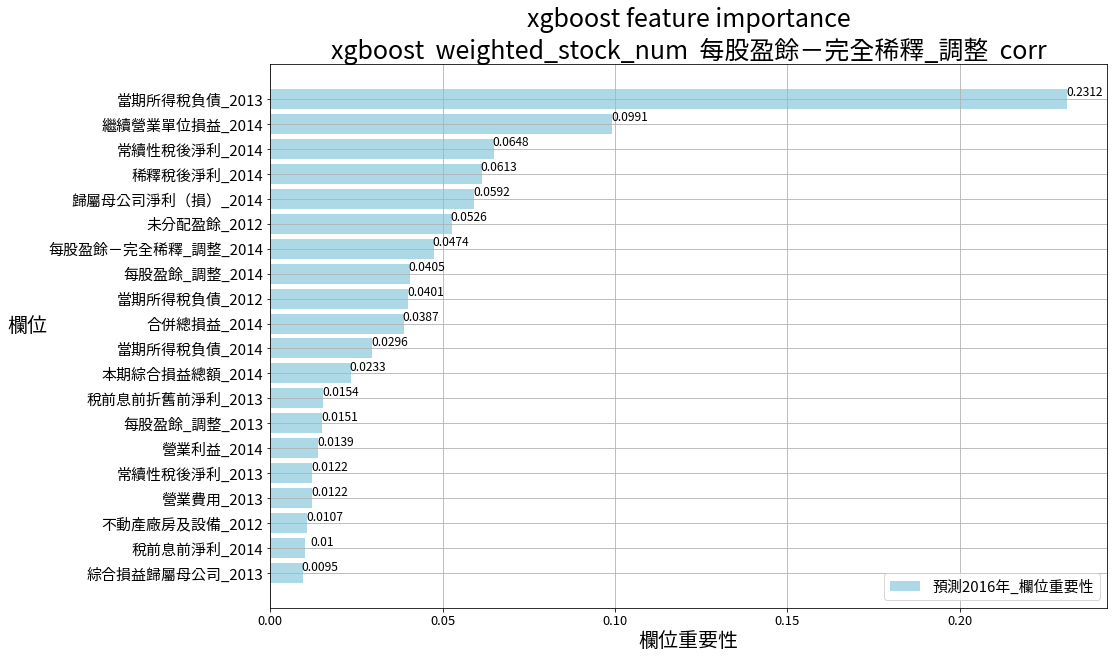

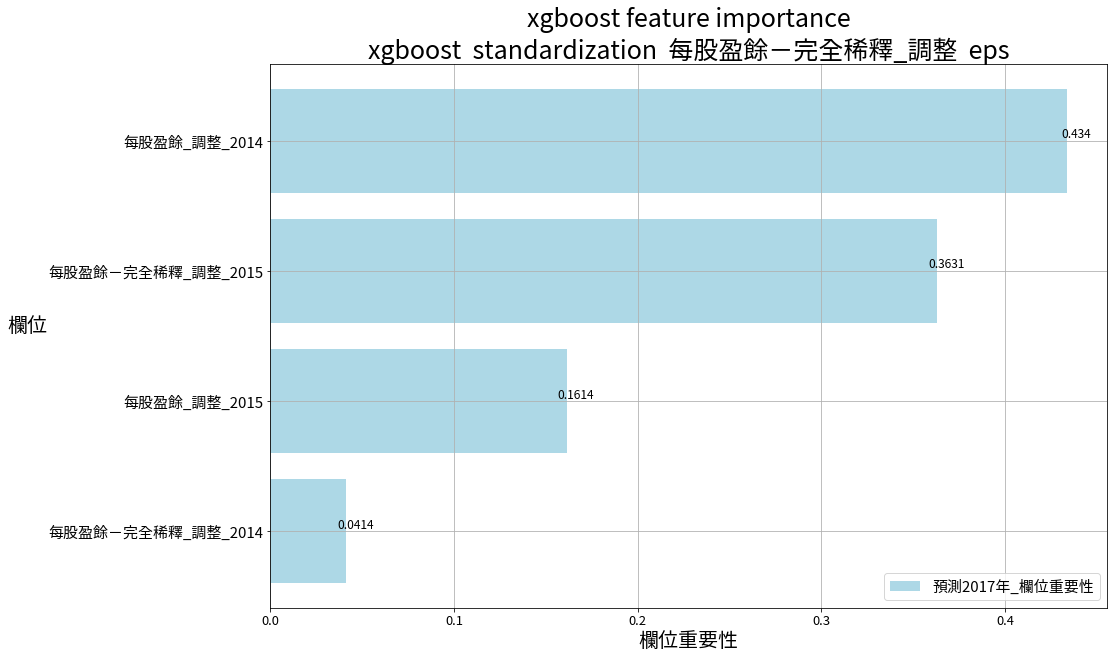

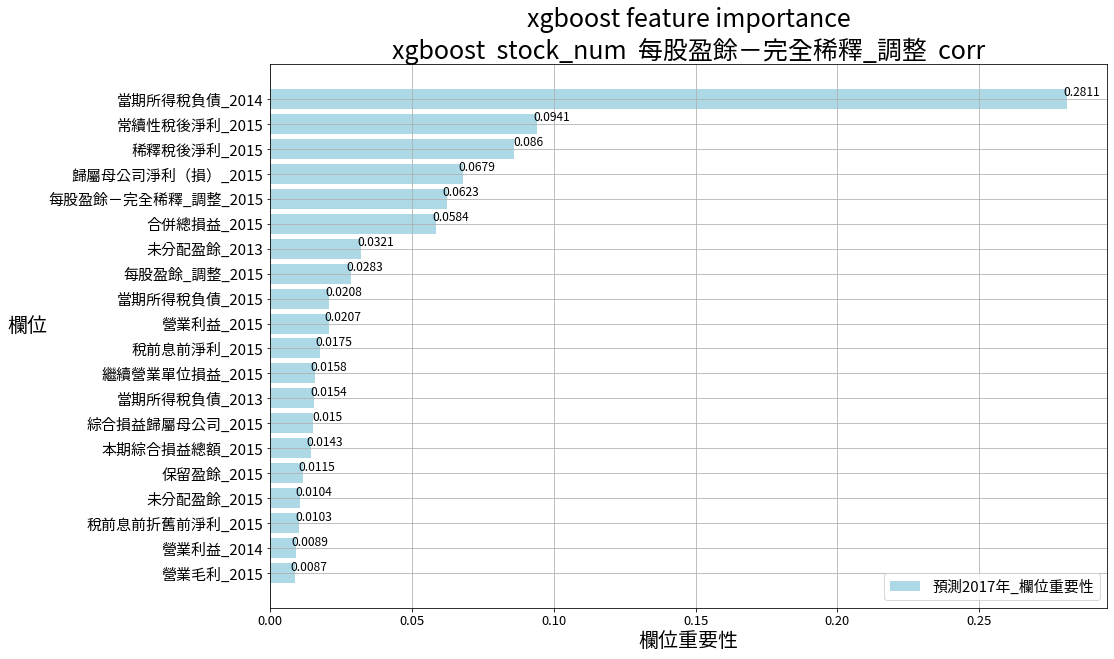

In [108]:
top_k_feat = 20
xgboost_feat_df_2016 = plot_feature_importance(pred_2016, 'xgboost', result_2016, str(2016), top_k_feat)
xgboost_feat_df_2017 = plot_feature_importance(pred_2017, 'xgboost', result_2017, str(2017), top_k_feat)
xgboost_feat_df_2017_2y = plot_feature_importance(pred_2017_2y, 'xgboost', result_2017_2y, str(2017), top_k_feat)

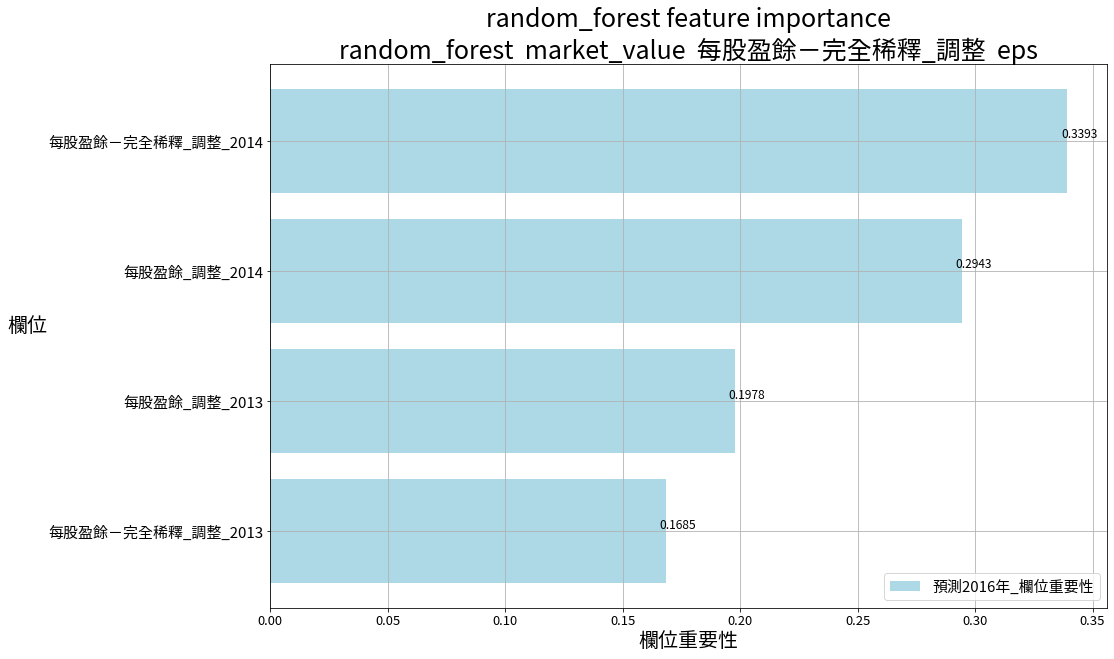

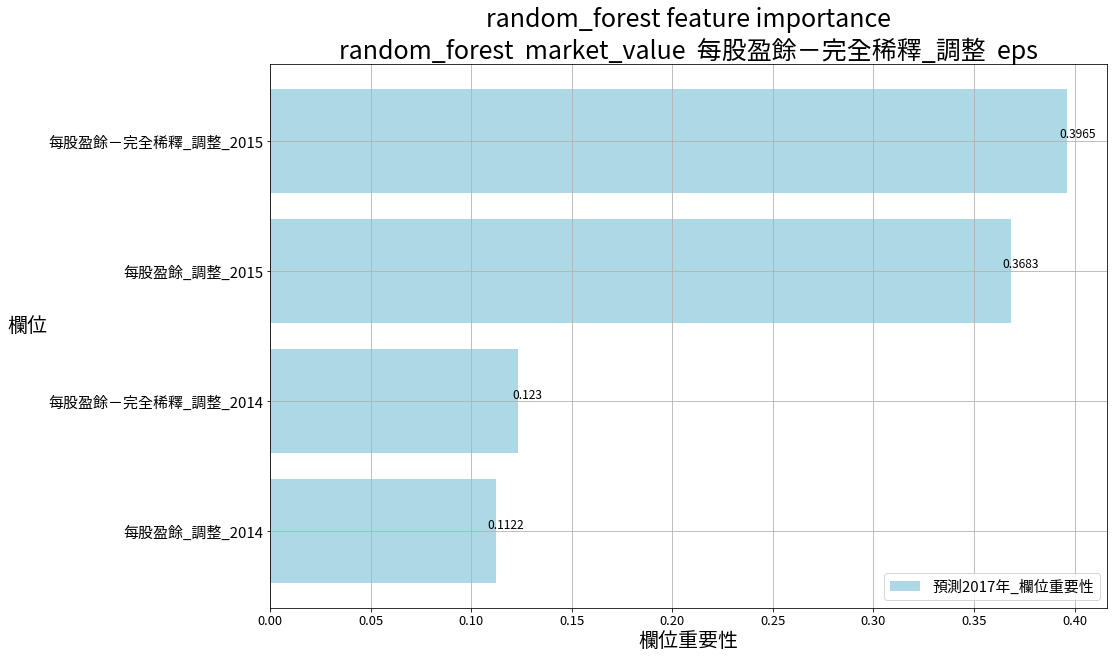

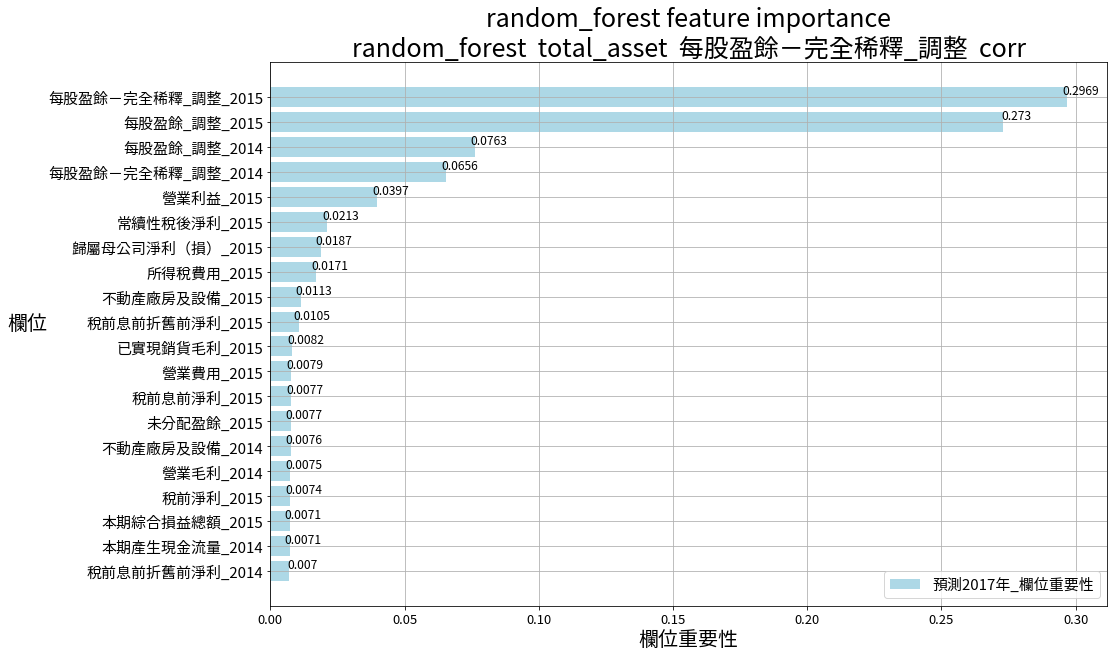

In [109]:
top_k_feat = 20
rf_feat_df_2016 = plot_feature_importance(pred_2016, 'random_forest', result_2016, str(2016), top_k_feat)
rf_feat_df_2017 = plot_feature_importance(pred_2017, 'random_forest', result_2017, str(2017), top_k_feat)
rf_feat_df_2017_2y = plot_feature_importance(pred_2017_2y, 'random_forest', result_2017_2y, str(2017), top_k_feat)